In [1]:
from __future__ import print_function

from datetime import datetime
import sys

from azure.storage.file import FileService
import azure.mgmt.batchai.models as models


# The BatchAI/utilities folder contains helper functions used by different notebooks

import utilities as utils
import utilities as utils
from utilities.job_factory import ParameterSweep, NumericParameter, DiscreteParameter

cfg = utils.config.Configuration('configuration.json')
client = utils.config.create_batchai_client(cfg)
## the below message : Keyring cache token has failed: (1783, 'CredWrite', 'The stub received bad data') is not a problem
## source https://stackoverflow.com/questions/50123247/azure-python-sdk-authentication-error

Keyring cache token has failed: (1783, 'CredWrite', 'The stub received bad data')


In [2]:
utils.config.create_resource_group(cfg)
_ = client.workspaces.create(cfg.resource_group, cfg.workspace, cfg.location).result()

Keyring cache token has failed: (1783, 'CredWrite', 'The stub received bad data')


In [3]:
nodes_count = 4
cluster_name = 'nc6'

parameters = models.ClusterCreateParameters(
    location=cfg.location,
    vm_size='STANDARD_NC6',
    scale_settings=models.ScaleSettings(
        manual=models.ManualScaleSettings(target_node_count=nodes_count)
    ),
    user_account_settings=models.UserAccountSettings(
        admin_user_name=cfg.admin,
        admin_user_password=cfg.admin_password or None,
        admin_user_ssh_public_key=cfg.admin_ssh_key or None,
    )
)

location is not a known attribute of class <class 'azure.mgmt.batchai.models.cluster_create_parameters_py3.ClusterCreateParameters'> and will be ignored


In [4]:
_ = client.clusters.create(cfg.resource_group, cfg.workspace, cluster_name, parameters).result()

In [5]:
cluster = client.clusters.get(cfg.resource_group, cfg.workspace, cluster_name)
utils.cluster.print_cluster_status(cluster)

Cluster state: steady Target: 4; Allocated: 0; Idle: 0; Unusable: 0; Running: 0; Preparing: 0; Leaving: 0
Cluster error: ClusterCoreQuotaReached: Operation results in exceeding quota limits of Standard NC Family Cluster Dedicated vCPUs. Maximum allowed: 24, Current in use: 24, Additional requested: 24. Please contact support to increase the quota for resource type Standard NC Family Cluster Dedicated vCPUs


In [ ]:
#### model of train.py adapted from :https://github.com/jocicmarko/ultrasound-nerve-segmentation

In [ ]:
### docker image registry :
#https://github.com/tensorflow/tensorflow/blob/master/tensorflow/tools/docker/README.md

In [6]:
### use hyper parameter search
import utilities as utils
from utilities.job_factory import ParameterSweep, NumericParameter, DiscreteParameter
param_specs = [
 DiscreteParameter(
        parameter_name="EPOCH",
        values=[1, 2]
    ),
    DiscreteParameter(
        parameter_name="BATCH_SIZE",
        values=[28, 32, 64]
    )
]

In [7]:
parameters = ParameterSweep(param_specs)

In [8]:
backend = 'tensorflow'
azure_file_share_name = 'datasets'
azure_file_share_subdir='ultrasound'

In [9]:
azure_file_share_mount_path = 'afs'
#azure_blob_mount_path = 'bfs'
jcp = models.JobCreateParameters(
    cluster=models.ResourceId(id=cluster.id),
    node_count=1,
        job_preparation=models.JobPreparation(command_line='python -m pip install keras scikit-image scikit-learn opencv-contrib-python-headless pillow numpy'),
        ####### only comment out the below when you use dsvm instead of docker image in parameters block above
         container_settings=models.ContainerSettings(
             image_source_registry=models.ImageSourceRegistry(image='tensorflow/tensorflow:1.4.0-gpu-py3')),
     mount_volumes=models.MountVolumes(
            azure_file_shares=[
            models.AzureFileShareReference(
            account_name=cfg.storage_account_name,
            credentials=models.AzureStorageCredentialsInfo(
            account_key=cfg.storage_account_key),
            azure_file_url='https://{0}.file.core.windows.net/{1}'.format(
            cfg.storage_account_name, 'datasets'), ## datasets is the name of the fileshare
            relative_mount_path='afs')
            ]
         ),
  std_out_err_path_prefix='$AZ_BATCHAI_JOB_MOUNT_ROOT/afs/ultrasound', ## here afs equal to bloodshare level
        tensor_flow_settings=models.TensorFlowSettings(
             python_script_file_path='$AZ_BATCHAI_JOB_MOUNT_ROOT/afs/ultrasound/train.py',
        master_command_line_args='--parent $AZ_BATCHAI_JOB_MOUNT_ROOT/afs/ultrasound/ --load_model N --epoch {0} --batch_size {1}'.format(parameters['EPOCH'], parameters['BATCH_SIZE'])))


In [ ]:
""" # no hyper param search
if backend == 'tensorflow':
    parameters = models.JobCreateParameters(
        #location=cfg.location,
        cluster=models.ResourceId(id=cluster.id),
        node_count=1,
        job_preparation=models.JobPreparation(command_line='python -m pip install keras scikit-image scikit-learn opencv-contrib-python-headless pillow numpy'),
        ####### only comment out the below when you use dsvm instead of docker image in parameters block above
         container_settings=models.ContainerSettings(
             image_source_registry=models.ImageSourceRegistry(image='tensorflow/tensorflow:1.4.0-gpu-py3')),
        ######### commend end #########################
        mount_volumes=models.MountVolumes(
            azure_file_shares=[
            models.AzureFileShareReference(
            account_name=cfg.storage_account_name,
            credentials=models.AzureStorageCredentialsInfo(
            account_key=cfg.storage_account_key),
            azure_file_url='https://{0}.file.core.windows.net/{1}'.format(
            cfg.storage_account_name, 'datasets'), ## datasets is the name of the fileshare
            relative_mount_path='afs')
            ]
         ),
        std_out_err_path_prefix='$AZ_BATCHAI_JOB_MOUNT_ROOT/afs/ultrasound', ## here afs equal to bloodshare level
        tensor_flow_settings=models.TensorFlowSettings(
             python_script_file_path='$AZ_BATCHAI_JOB_MOUNT_ROOT/afs/ultrasound/train.py',
        master_command_line_args='--parent $AZ_BATCHAI_JOB_MOUNT_ROOT/afs/ultrasound/ --load_model N --epoch 1')) 

"""


In [10]:
experiment_name = 'unet_random_hyperparam_search_experiment'
experiment = client.experiments.create(cfg.resource_group, cfg.workspace, experiment_name).result()
# Generate Jobs
num_configs = 4 # num of combination you_want to have
jobs_to_submit, param_combinations = parameters.generate_jobs_random_search(jcp, num_configs)

# Print the parameter combinations generated
for idx, comb in enumerate(param_combinations):
    print("Parameters {0}: {1}".format(idx + 1, comb))

# Submit Jobs
experiment_utils = utils.experiment.ExperimentUtils(client, cfg.resource_group, cfg.workspace, experiment_name)
jobs = experiment_utils.submit_jobs(jobs_to_submit, 'unet_hyperparams_job').result()

Parameters 1: {'PARAM_EPOCH': 2, 'PARAM_BATCH_SIZE': 32}
Parameters 2: {'PARAM_EPOCH': 1, 'PARAM_BATCH_SIZE': 28}
Parameters 3: {'PARAM_EPOCH': 1, 'PARAM_BATCH_SIZE': 28}
Parameters 4: {'PARAM_EPOCH': 2, 'PARAM_BATCH_SIZE': 64}
Initialized JobSubmitter in resource group: batchairg | workspace: zbatchai | experiment: unet_random_hyperparam_search_experiment
Created job "unet_hyperparams_job_815be0586c890c0f" with parameters {"PARAM_BATCH_SIZE": "28", "PARAM_EPOCH": "1"}
Created job "unet_hyperparams_job_f754a4996877925d" with parameters {"PARAM_BATCH_SIZE": "64", "PARAM_EPOCH": "2"}
Created job "unet_hyperparams_job_815be0586c890c0f" with parameters {"PARAM_BATCH_SIZE": "28", "PARAM_EPOCH": "1"}
Created job "unet_hyperparams_job_32a0000e7809d3c6" with parameters {"PARAM_BATCH_SIZE": "32", "PARAM_EPOCH": "2"}


In [11]:
# Wait for all jobs to complete
experiment_utils.wait_all_jobs()


0/3 jobs completed (0 succeeded, 0 failed)...............
0/3 jobs completed (0 succeeded, 0 failed)...............
0/3 jobs completed (0 succeeded, 0 failed)...............
0/3 jobs completed (0 succeeded, 0 failed)...............
0/3 jobs completed (0 succeeded, 0 failed)...............
0/3 jobs completed (0 succeeded, 0 failed)...............
0/3 jobs completed (0 succeeded, 0 failed)...............
0/3 jobs completed (0 succeeded, 0 failed)...............
0/3 jobs completed (0 succeeded, 0 failed)...............
0/3 jobs completed (0 succeeded, 0 failed)...............
0/3 jobs completed (0 succeeded, 0 failed)...............
0/3 jobs completed (0 succeeded, 0 failed)...............
0/3 jobs completed (0 succeeded, 0 failed)...............
0/3 jobs completed (0 succeeded, 0 failed)...............
0/3 jobs completed (0 succeeded, 0 failed)...............
0/3 jobs completed (0 succeeded, 0 failed)...............
0/3 jobs completed (0 succeeded, 0 failed)...............
0/3 jobs compl

In [ ]:
"""
experiment_name = 'unet_train'
experiment = client.experiments.create(cfg.resource_group, cfg.workspace, experiment_name).result()
job_name = datetime.utcnow().strftime('keras_{}_%m_%d_%Y_%H%M%S'.format(backend))
job = client.jobs.create(cfg.resource_group, cfg.workspace, experiment_name, job_name, parameters).result()
print('Created Job {0} in Experiment {1}'.format(job.name, experiment.name))
"""

In [ ]:
"""
if backend == 'tensorflow':
    read_file = 'stdout-wk-0.txt'
elif backend == 'cntk':
    read_file = 'stdout.txt'

utils.job.wait_for_job_completion(client, cfg.resource_group, cfg.workspace, 
                                  experiment_name, job_name, cluster_name, 'stdouterr', read_file)
"""

In [12]:
from azure.storage.file import FileService
file_service = FileService(cfg.storage_account_name, cfg.storage_account_key)
generator = file_service.list_directories_and_files('datasets/ultrasound')
for file_or_dir in generator:
    print(file_or_dir.name, file_or_dir.metadata)

best_model_architect.json None
best_model_weights.h5 None
data.py None
data_preprocessing2npy.ipynb None
epoch1batch_size28checkpointweights.h5 None
epoch1batch_size28model_architecture.json None
epoch1batch_size28model_weights.h5 None
epoch2batch_size32checkpointweights.h5 None
epoch2batch_size32model_architecture.json None
epoch2batch_size32model_weights.h5 None
epoch2batch_size64checkpointweights.h5 None
epoch2batch_size64model_architecture.json None
epoch2batch_size64model_weights.h5 None
imgs_cv_test.npy None
imgs_cv_train.npy None
imgs_id_cv_test.npy None
imgs_id_test.npy None
imgs_mask_cv_train.npy None
imgs_mask_test.npy None
imgs_mask_train.npy None
imgs_test.npy None
imgs_train.npy None
keras_unet_train_ultrasound.ipynb None
train.py None
train_masks.csv None
60be94cf-bd71-4d05-b7ce-d05fb5968d66 None
test None
train None
__pycache__ None


In [16]:

_ = client.experiments.delete(cfg.resource_group, cfg.workspace, experiment_name).result()

In [17]:
_ = client.clusters.delete(cfg.resource_group, cfg.workspace, cluster_name)

## pull down the trained model and make prediction locally

In [18]:
from __future__ import print_function

import os
import numpy as np

from skimage.io import imsave, imread
import argparse
from data import load_test_data
image_rows = int(420)
image_cols = int(580)
data_path='./raw/'


In [19]:
#source citation: https://www.kaggle.com/chefele/plot-images-overlaid-with-mask/notebook
###plotting known image vs corresponding segmentation 
# helper functions to help plotting images

IMAGES_TO_SHOW = 10  # configure to taste :)


import numpy as np
import matplotlib.pyplot as plt
import glob, os, os.path
import cv2


def image_with_mask(img, mask):
    # returns a copy of the image with edges of the mask added in red
    img_color = grays_to_RGB(img)
    mask_edges = cv2.Canny(mask, 100, 200) > 0  
    img_color[mask_edges, 0] = 255  # set channel 0 to bright red, green & blue channels to 0
    img_color[mask_edges, 1] = 0
    img_color[mask_edges, 2] = 0
    return img_color

def fimg_to_fmask(img_path):
    # convert an image file path into a corresponding mask file path 
    dirname, basename = os.path.split(img_path)
    maskname = basename.replace(".tif", "_mask.tif")
    return os.path.join(dirname, maskname)

def mask_not_blank(mask):
    return sum(mask.flatten()) > 0

def grays_to_RGB(img):
    # turn 2D grayscale image into grayscale RGB
    return np.dstack((img, img, img)) 

def plot_image(img, title=None, figsize=(15,20)):
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.imshow(img)
    plt.show()


def process_test_sample(data_path):
    imgs_test, imgs_id_test = load_test_data(data_path)
    imgs_test = preprocess(imgs_test)

    imgs_test = imgs_test.astype('float32')
    imgs_show=imgs_test
    mean = np.mean(imgs_test)  # mean for data centering
    std = np.std(imgs_test) 
    imgs_test -= mean
    imgs_test /= std
    return imgs_test, imgs_id_test, imgs_show

def make_prediction(test_img):
    print('-'*30)
    print('Loading and preprocessing test data...')
    print('Predicting masks on test data...')
    print('-'*30)
    test_img=np.expand_dims(test_img, axis=0)
    imgs_mask_test = loaded_model.predict(test_img, verbose=1)
    #np.save(data_path+'imgs_mask_test.npy', imgs_mask_test)
    return imgs_mask_test


#imgs_test=process_test_sample(data_path)


In [20]:
from __future__ import print_function
import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam

from keras import backend as K
import argparse
from data import load_test_data
K.set_image_data_format('channels_last')  # TF dimension ordering in this code

img_rows = 96
img_cols = 96
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_cols, img_rows), preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p


# load json and create model
from keras.models import model_from_yaml
from keras.models import model_from_json
from keras import backend as K


# serialize model to JSON
import os
json_file = open('model_architecture.json', 'r')
loaded_model_json = json_file.read()
#json_file.close()

loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_weights.h5")
print("Loaded model from disk")
from keras.optimizers import Adam
loaded_model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

Using TensorFlow backend.


Loaded model from disk


In [21]:
imgs_test, imgs_id_test, imgs_show=process_test_sample(data_path)

c:\users\zecharpy\appdata\local\continuum\anaconda3\envs\py36_zbatchai\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\zecharpy\appdata\local\continuum\anaconda3\envs\py36_zbatchai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


idx 1.tif
------------------------------
Loading and preprocessing test data...
Predicting masks on test data...
------------------------------
1/1 [==============================] - 0s 174ms/step


c:\users\zecharpy\appdata\local\continuum\anaconda3\envs\py36_zbatchai\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


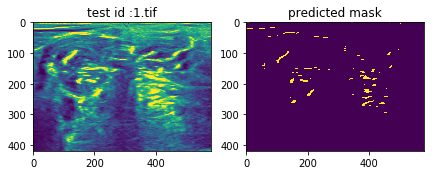

idx 10.tif
------------------------------
Loading and preprocessing test data...
Predicting masks on test data...
------------------------------
1/1 [==============================] - 0s 69ms/step


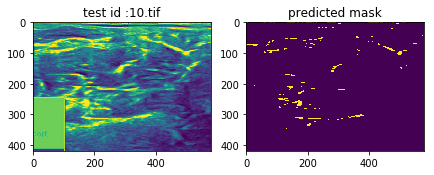

idx 100.tif
------------------------------
Loading and preprocessing test data...
Predicting masks on test data...
------------------------------
1/1 [==============================] - 0s 53ms/step


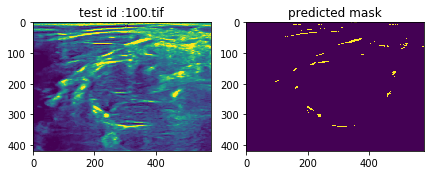

idx 1000.tif
------------------------------
Loading and preprocessing test data...
Predicting masks on test data...
------------------------------
1/1 [==============================] - 0s 52ms/step


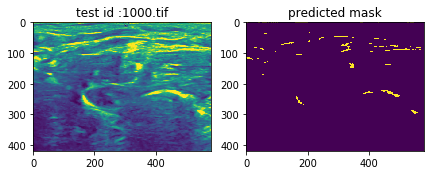

idx 1001.tif
------------------------------
Loading and preprocessing test data...
Predicting masks on test data...
------------------------------
1/1 [==============================] - 0s 63ms/step


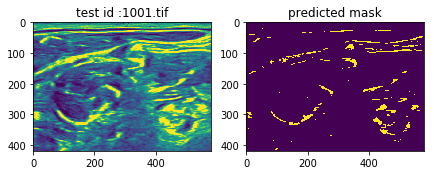

idx 1002.tif
------------------------------
Loading and preprocessing test data...
Predicting masks on test data...
------------------------------
1/1 [==============================] - 0s 73ms/step


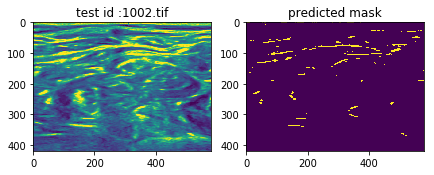

idx 1003.tif
------------------------------
Loading and preprocessing test data...
Predicting masks on test data...
------------------------------
1/1 [==============================] - 0s 52ms/step


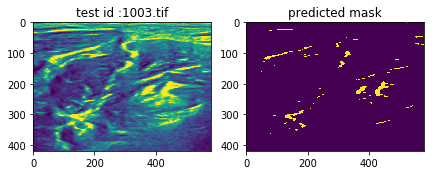

idx 1004.tif
------------------------------
Loading and preprocessing test data...
Predicting masks on test data...
------------------------------
1/1 [==============================] - 0s 39ms/step


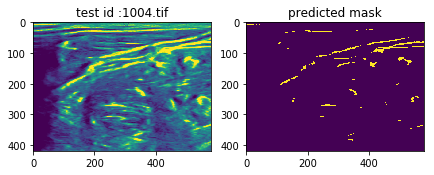

idx 1005.tif
------------------------------
Loading and preprocessing test data...
Predicting masks on test data...
------------------------------
1/1 [==============================] - 0s 43ms/step


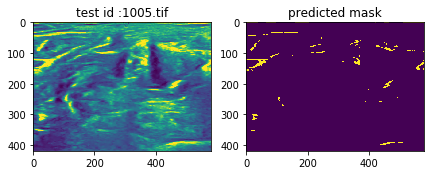

idx 1006.tif
------------------------------
Loading and preprocessing test data...
Predicting masks on test data...
------------------------------
1/1 [==============================] - 0s 62ms/step


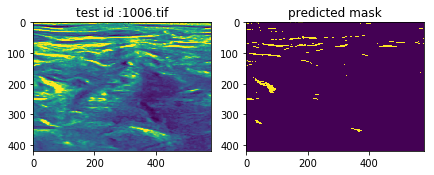

idx 1007.tif
------------------------------
Loading and preprocessing test data...
Predicting masks on test data...
------------------------------
1/1 [==============================] - 0s 73ms/step


In [22]:
### plot predictions
import random
from skimage.transform import rescale, resize, downscale_local_mean
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize
%matplotlib inline
#imgs_id_test=imgs_id_test.tolist()
imgs_id_list=[str(idx)+'.tif' for idx in imgs_id_test ]
#test_samples=imgs_show[random.sample(range(1,5508),7)]
IMAGES_TO_SHOW= 5*2

f_ultrasounds = [img for img in imgs_show]

figsize(7, 5)
fig = plt.figure()


images_shown = 0 

for idx ,f_ultrasound in zip(imgs_id_list,f_ultrasounds):
    print("idx",idx)
    ## making prediction
    f_mask=make_prediction(imgs_test[int(idx.split('.')[0])])
    img  = plt.imread("./raw/test/"+idx)
    #print("img shape",img.shape)
    #print("ultra shape and mask shape", f_ultrasound.shape, f_mask.shape)
    if images_shown >= IMAGES_TO_SHOW:
        break
    
    if mask_not_blank(f_mask):
        f_combined = "image id: "+ str(idx) + "predicted segmentation"  
        img_color = grays_to_RGB(f_ultrasound)
        #print("shape", img_color.shape)
        f_ultrasound=f_ultrasound.astype(np.uint8)
        
        f_mask_resize = resize(img, ( 420,580 ),anti_aliasing=True)
        f_mask_resize=f_mask_resize.astype(np.uint8)
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title("test id :{}".format(str(idx)))
        plt.subplot(1, 2, 2)
        plt.imshow(f_mask_resize)
        plt.title("predicted mask")
        plt.show()
        #print("ultra shape and mask shape", img.shape, f_mask_resize.shape)
        #plot_image(image_with_mask(img, f_mask_resize), title=f_combined)
        #print('plotted:', f_combined)
        images_shown += 1